# Fine-tuning GPT-2 

In [1]:
import pandas as pd
import re
import itertools
import os

source https://github.com/piegu/fastai-projects/blob/master/finetuning-English-GPT2-any-language-Portuguese-HuggingFace-fastaiv2.ipynb

## Get wiki 

In [ ]:
# Download wiki
# pip install wikiextractor
# wget -c https://dumps.wikimedia.org/frwiki/latest/frwiki-latest-pages-articles.xml.bz2

# Unzip
# bzip2 -dk frwiki-latest-pages-articles.xml.bz2

# Extract xml dump (need multiprocesses so go to Colab)
# python3 -m wikiextractor.WikiExtractor --processes 40 --no-templates -b 100G frwiki-latest-pages-articles.xml

#mv text/AA/wiki_00 wiki_00


In [1]:
# Split wiki into csv 

title_re = re.compile(rf'^<doc id="\d+" url="(?:https://fr.wikipedia.org/wiki)?\?curid=\d+" title="([^"]+)">$')

df = pd.DataFrame.from_dict({'text': []})
df.to_csv('./dataframe.csv', index=False)

In [ ]:
file = open('./wiki_00', mode="r")

df = pd.read_csv('./dataframe.csv')

articles = []
article = ""
i = 0
start = 0
stop = 10
while True:
  # if i < start:
  #   l = file.readline()
  #   if l.startswith('<doc id="'):
  #     i += 1

  l = file.readline()

  if not l:
    break
  
  if i == stop:
    break

  if l.startswith('<doc id="'):
    print(i)
    if article != "":
      articles.append(article)
      article = ""
      i += 1
      if (i%100000 == 0):
        dftemp = pd.DataFrame.from_dict({'text': articles})
        df = df.append(dftemp)
        df.to_csv('./dataframe.csv', index=False)
        articles = []

  else:
    article += l

file.close()
df.head()

In [21]:
df = pd.read_csv('./data/dataframe.csv')

In [32]:
# Preprocess
df['text'] = df['text'].str.replace('</doc>','')

In [33]:
df.to_csv('./data/dataframe.csv', index=False)

In [38]:
# Create all_texts.txt for vocab
text_list = list(df['text'])
with open('./data/all_texts.txt', 'w') as f:
    for comment in text_list:
      f.write(comment)

## Initialization

In [6]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

In [12]:
pretrained_weights = 'gpt2'
tokenizer_en = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model_en = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [13]:
tokenizer_en.pad_token = tokenizer_en.eos_token


Check the GPT2 model config (config of GPT2LMHeadModel)¶


In [5]:
model_en.config

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.9.1",
  "use_cache": true,
  "vocab_size": 50257
}


Check the GPT2 tokenizer config (config of GPT2TokenizerFast pre-trained in English)

In [14]:
# source: https://huggingface.co/transformers/_modules/transformers/tokenization_utils_fast.html
    
# print('short-cut-names:',tokenizer_en.short-cut-names) 
# print()  

print('max_model_input_sizes')
for k,v in tokenizer_en.max_model_input_sizes.items():
    print('- ',k,v)
print()
    
print('model_max_length:',tokenizer_en.model_max_length)
print()

for k,v in tokenizer_en.pretrained_init_configuration.items():
    print(k,v)
    
print('padding_side:',tokenizer_en.padding_side)
print()

print('model_input_names:',tokenizer_en.model_input_names)
print()

print('bos_token & bos_token_id:',tokenizer_en.bos_token,tokenizer_en.bos_token_id)
print()

print('eos_token & eos_token_id:',tokenizer_en.eos_token,tokenizer_en.eos_token_id)
print()

print('unk_token & unk_token_id:',tokenizer_en.unk_token,tokenizer_en.unk_token_id)
print()

print('sep_token:',tokenizer_en.sep_token)
print()

print('pad_token, pad_token_id & pad_token_type_id:',tokenizer_en.pad_token,tokenizer_en.pad_token_id,tokenizer_en.pad_token_type_id)
print()

print('cls_token:',tokenizer_en.cls_token)
print()

print('mask_token:',tokenizer_en.mask_token)
print()

print('additional_special_tokens:',tokenizer_en.additional_special_tokens)
print()

print('all_special_tokens & all_special_ids:',tokenizer_en.all_special_tokens,tokenizer_en.all_special_ids)
print()

print('---------- vocab ----------')
print()

print('vocab_files_names:',tokenizer_en.vocab_files_names)
print()

for k,v in tokenizer_en.pretrained_vocab_files_map.items():
    print(k)
    for kk,vv in v.items():
        print('- ',kk,':',vv)
    print()
    
print('vocab_size:',tokenizer_en.vocab_size)
print()
#print(tokenizer_en.get_vocab())

num = 20
print(f'First {num} items of the vocab: {dict(itertools.islice(tokenizer_en.get_vocab().items(), 20))}')

Using sep_token, but it is not set yet.
Using cls_token, but it is not set yet.
Using mask_token, but it is not set yet.


max_model_input_sizes
-  gpt2 1024
-  gpt2-medium 1024
-  gpt2-large 1024
-  gpt2-xl 1024
-  distilgpt2 1024

model_max_length: 1024

padding_side: right

model_input_names: ['input_ids', 'attention_mask']

bos_token & bos_token_id: <|endoftext|> 50256

eos_token & eos_token_id: <|endoftext|> 50256

unk_token & unk_token_id: <|endoftext|> 50256

sep_token: None

pad_token, pad_token_id & pad_token_type_id: <|endoftext|> 50256 0

cls_token: None

mask_token: None

additional_special_tokens: []

all_special_tokens & all_special_ids: ['<|endoftext|>'] [50256]

---------- vocab ----------

vocab_files_names: {'vocab_file': 'vocab.json', 'merges_file': 'merges.txt', 'tokenizer_file': 'tokenizer.json'}

vocab_file
-  gpt2 : https://huggingface.co/gpt2/resolve/main/vocab.json
-  gpt2-medium : https://huggingface.co/gpt2-medium/resolve/main/vocab.json
-  gpt2-large : https://huggingface.co/gpt2-large/resolve/main/vocab.json
-  gpt2-xl : https://huggingface.co/gpt2-xl/resolve/main/vocab.json
- 

In [15]:
# Get GPT2 tokenizer_en vocab size
ByteLevelBPE_tokenizer_fr_vocab_size = tokenizer_en.vocab_size
ByteLevelBPE_tokenizer_fr_vocab_size


50257

In [16]:
# ByteLevelBPETokenizer Represents a Byte-level BPE as introduced by OpenAI with their GPT-2 model
from tokenizers import ByteLevelBPETokenizer

ByteLevelBPE_tokenizer_fr = ByteLevelBPETokenizer()

# Get list of paths to corpus files
path_data = './data'
paths = [os.path.join(path_data, 'all_texts.txt')]
# Customize training with <|endoftext|> special GPT2 token
ByteLevelBPE_tokenizer_fr.train(files=paths, 
                                vocab_size=ByteLevelBPE_tokenizer_fr_vocab_size, 
                                min_frequency=2, 
                                special_tokens=["<|endoftext|>"])

# Get sequence length max of 1024
ByteLevelBPE_tokenizer_fr.enable_truncation(max_length=512)

# save tokenizer
ByteLevelBPE_tokenizer_fr_rep = 'ByteLevelBPE_tokenizer_fr'
path_to_ByteLevelBPE_tokenizer_fr_rep = os.path.join(path_data, ByteLevelBPE_tokenizer_fr_rep)
if not os.path.exists(path_to_ByteLevelBPE_tokenizer_fr_rep):
    os.mkdir(path_to_ByteLevelBPE_tokenizer_fr_rep)
ByteLevelBPE_tokenizer_fr.save_model(str(path_to_ByteLevelBPE_tokenizer_fr_rep))

['./data/ByteLevelBPE_tokenizer_fr/vocab.json',
 './data/ByteLevelBPE_tokenizer_fr/merges.txt']

Check our tokenizer

In [17]:
# Load the tokenizer ByteLevelBPE_tokenizer_fr
from tokenizers import ByteLevelBPETokenizer

# Get the path to ByteLevelBPE_tokenizer_fr config files
ByteLevelBPE_tokenizer_fr_rep = 'ByteLevelBPE_tokenizer_fr'
path_to_ByteLevelBPE_tokenizer_fr_rep = os.path.join(path_data, ByteLevelBPE_tokenizer_fr_rep)

ByteLevelBPE_tokenizer_fr = ByteLevelBPETokenizer(
    vocab=f'{path_to_ByteLevelBPE_tokenizer_fr_rep}/vocab.json',
    merges=f'{path_to_ByteLevelBPE_tokenizer_fr_rep}/merges.txt'
)

# Get sequence length max of 1024
ByteLevelBPE_tokenizer_fr.enable_truncation(max_length=1024)

In [51]:
# Get vocab as a list
ByteLevelBPE_tokenizer_fr_vocab = ByteLevelBPE_tokenizer_fr.get_vocab() 
ByteLevelBPE_tokenizer_fr_vocab_ls = [k for k, v in sorted(ByteLevelBPE_tokenizer_fr_vocab.items(), key=lambda item: item[1])]
len(ByteLevelBPE_tokenizer_fr_vocab_ls),ByteLevelBPE_tokenizer_fr_vocab_ls[:5]

(50257, ['<|endoftext|>', '!', '"', '#', '$'])

In [52]:
text = "C'est <name> bon trimestre."
output = ByteLevelBPE_tokenizer_fr.encode(text)
output.ids,output.tokens,output.offsets


([35, 7, 303, 221, 28, 78, 1432, 30, 3064, 28362, 14],
 ['C', "'", 'est', 'Ġ', '<', 'n', 'ame', '>', 'Ġbon', 'Ġtrimestre', '.'],
 [(0, 1),
  (1, 2),
  (2, 5),
  (5, 6),
  (6, 7),
  (7, 8),
  (8, 11),
  (11, 12),
  (12, 16),
  (16, 26),
  (26, 27)])

In [53]:
back_to_text = ByteLevelBPE_tokenizer_fr.decode(ByteLevelBPE_tokenizer_fr.encode(text).ids)

print('input text:', text)
print('tokens ids:', output.ids)
print('back to text:', back_to_text)


input text: C'est <name> bon trimestre.
tokens ids: [35, 7, 303, 221, 28, 78, 1432, 30, 3064, 28362, 14]
back to text: C'est <name> bon trimestre.


Import the tokenizer config files in French into the pre-trained GPT2 Tokenizer

In [18]:
# import the pre-trained GPT2TokenizerFast tokenizer with the tokenizer_fr config files
tokenizer_fr = GPT2TokenizerFast.from_pretrained(
    str(path_to_ByteLevelBPE_tokenizer_fr_rep), 
    pad_token='<|endoftext|>')

# Get sequence length max of 1024
tokenizer_fr.model_max_length = 1024

file ./data/ByteLevelBPE_tokenizer_fr/config.json not found
file ./data/ByteLevelBPE_tokenizer_fr/config.json not found


In [55]:
# Check
text = "C'est vraiment très bien."
tokens_ids = tokenizer_fr.encode(text)
back_to_text = tokenizer_fr.decode(tokenizer_fr.encode(text))

print('input text:', text)
print('tokens ids:', tokens_ids)
print('back to text:', back_to_text)


input text: C'est vraiment très bien.
tokens ids: [35, 7, 303, 9759, 802, 1049, 14]
back to text: C'est vraiment très bien.


## Create a fastai tokenizer and update the embeddings matrix of the GPT-2 English pre-trained model

In [4]:
from fastai.text.all import *

In [19]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [58]:
# Load the GPT2 tokenizer in English
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
pretrained_weights = 'gpt2'
tokenizer_en = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model_en = GPT2LMHeadModel.from_pretrained(pretrained_weights)

# To correct the warning about token_pad (GPT2TokenizerFast), run the following code
# source: https://github.com/huggingface/transformers/issues/2648#issuecomment-616177044
tokenizer_en.pad_token = tokenizer_en.eos_token

In [60]:
# Test of the class TransformersTokenizer of fastai with tokenizer_en
tokenizer_fastai_en = TransformersTokenizer(tokenizer_en)
text = "Maybe, you're right"
tokens_ids = tokenizer_fastai_en.encodes(text)
tokens = tokenizer_fastai_en.tokenizer.convert_ids_to_tokens(tokens_ids)

print('input text:',TitledStr(text))
print('text tokens:',TitledStr(tokens))
print('text tokens_ids:',TitledStr(tokens_ids))
print('output text:',TitledStr(tokenizer_fastai_en.decodes(tokens_ids)))

input text: Maybe, you're right
text tokens: ['Maybe', ',', 'Ġyou', "'re", 'Ġright']
text tokens_ids: tensor([13300,    11,   345,   821,   826])
output text: Maybe, you're right


In [61]:
# Test of the class TransformersTokenizer of fastai with tokenizer_fr
tokenizer_fastai_fr = TransformersTokenizer(tokenizer_fr)
text = "Peut être que vous avez raison"
tokens_ids = tokenizer_fastai_fr.encodes(text)
tokens = tokenizer_fastai_fr.tokenizer.convert_ids_to_tokens(tokens_ids)

print('input text:',TitledStr(text))
print('text tokens:',TitledStr(tokens))
print('text tokens_ids:',TitledStr(tokens_ids))
print('output text:',TitledStr(tokenizer_fastai_fr.decodes(tokens_ids)))

input text: Peut être que vous avez raison
text tokens: ['P', 'eut', 'ĠÃªtre', 'Ġque', 'Ġvous', 'Ġavez', 'Ġraison']
text tokens_ids: tensor([   48,  9785,   771,   383,  6383, 35239,  1929])
output text: Peut être que vous avez raison


In [62]:
tokenizer_fastai_en = TransformersTokenizer(tokenizer_en)
old_vocab_size = tokenizer_fastai_en.tokenizer.vocab_size

tokenizer_fastai_fr = TransformersTokenizer(tokenizer_fr)
new_vocab_size = tokenizer_fastai_fr.tokenizer.vocab_size

old_vocab_size,new_vocab_size,old_vocab_size-new_vocab_size

(50257, 50257, 0)

Check vocabs

In [63]:
tokenizer_fastai_vocab_en = tokenizer_fastai_en.tokenizer.get_vocab()
tokenizer_fastai_vocab_ls_en = [k for k, v in sorted(tokenizer_fastai_vocab_en.items(), key=lambda item: item[1])]
len(tokenizer_fastai_vocab_ls_en),tokenizer_fastai_vocab_ls_en[:10]

(50257, ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*'])

In [64]:
tokenizer_fastai_vocab_fr = tokenizer_fastai_fr.tokenizer.get_vocab() 
tokenizer_fastai_vocab_ls_fr = [k for k, v in sorted(tokenizer_fastai_vocab_fr.items(), key=lambda item: item[1])]
len(tokenizer_fastai_vocab_ls_fr),tokenizer_fastai_vocab_ls_fr[:10]

(50257, ['<|endoftext|>', '!', '"', '#', '$', '%', '&', "'", '(', ')'])


Changing vocabs and the vocab embeddings matrix (ie, setup new embeddings matrix)

In [65]:
# Check atual weight of wte and lm_head and if wte = lm_head
tens_a = model_en.transformer.wte.weight
tens_b = model_en.lm_head.weight
model_en.transformer.wte.weight,model_en.lm_head.weight,torch.all(tens_a.eq(tens_b))

(Parameter containing:
 tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
         [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
         [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
         ...,
         [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
         [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
         [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
         [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
         [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
         ...,
         [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
         [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
         [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]],
        requires_grad=True),
 tensor(True))

In [66]:
# Get weights of the old wte
old_wgts = model_en.transformer.get_input_embeddings().weight.clone().detach()

# Get the mean embedding vetor of the old wte
wgts_m = old_wgts.mean(0)

# Initialize vocab size and weights of the new wte
new_vocab_size = tokenizer_fastai_fr.tokenizer.vocab_size
new_wgts = old_wgts.new_zeros(new_vocab_size,old_wgts.size(1))

## Save

In [68]:
# Get the new wte keeping the embeddings vetors of tokens in common in the 2 vocabs
# A token present in the new vocab but not in the old one gets the mean embedding vetor of the old wte
old_vocab = tokenizer_fastai_en.tokenizer.get_vocab()
new_vocab = tokenizer_fastai_fr.tokenizer.get_vocab()
same_tokens_list = list()
different_tokens_list = list()
    
for w,idx_new in new_vocab.items():    
    idx_old = old_vocab.get(w, -1)
    if idx_old>=0:
        new_wgts[idx_new] = old_wgts[idx_old]
        same_tokens_list.append((w,idx_new))
    else:
        new_wgts[idx_new] = wgts_m
        different_tokens_list.append((w,idx_new))

# setup in model the new wte
new_wte = nn.Embedding(new_vocab_size,old_wgts.size(1))
#new_wte.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
new_wte.weight.data = new_wgts
model_en.transformer.set_input_embeddings(new_wte)
print(f'French wte matrix setup done!\n\nWe kept {len(same_tokens_list)} embeddings vectors from the English one.\nWe did not kept {len(different_tokens_list)} embeddings vectors from the English one (instead, we used the old wte mean vector).\n')

# Check identical tokens between the 2 vocabs               
num = 15
print(f'{num} first tokens IN common between the 2 vocabs:\n{same_tokens_list[:num]}\n')
print(f'{num} first tokens NOT in common between the 2 vocabs:\n{different_tokens_list[:num]}')

# save new_wgts
torch.save(new_wgts, os.path.join(path_data, 'new_wte_wgts.pt'))
# save same_tokens_list and different_tokens_list
torch.save(same_tokens_list, os.path.join(path_data, 'same_tokens_list.pt'))
torch.save(different_tokens_list, os.path.join(path_data, 'different_tokens_list.pt'))

French wte matrix setup done!

We kept 14543 embeddings vectors from the English one.
We did not kept 35714 embeddings vectors from the English one (instead, we used the old wte mean vector).

15 first tokens IN common between the 2 vocabs:
[('Penn', 40878), ('roit', 3140), ('nesota', 19516), ('Ġlat', 32571), ('Na', 37924), ('Ġtransitions', 43503), ('Ġtrim', 17934), ('2003', 11007), ('ÿ', 188), ('hua', 22875), ('Ġformats', 18986), ('Ġtalk', 49921), ('Ö', 147), ('Ġind', 1323), ('Ġinval', 32738)]

15 first tokens NOT in common between the 2 vocabs:
[('Ġperdu', 4712), ('ĠprÃ©dication', 38492), ('Ġusagers', 21322), ('Ġchemins', 6456), ('Ã¶m', 28601), ('ĠcÃ©lÃ©britÃ©', 21688), ('raÃ«l', 6274), ('Ġavent', 28748), ('ĠHuit', 29695), ('Ġrapportant', 29003), ('ĠprÃ©sentait', 18987), ('Ġfluviale', 32582), ('Oul', 44873), ('ĠFrederik', 46841), ('Ġbourgs', 24851)]


## Load

In [69]:
# load new_wgts
new_wgts = torch.load(os.path.join(path_data, 'new_wte_wgts.pt'))
# load same_tokens_list and different_tokens_list
same_tokens_list = torch.load(os.path.join(path_data, 'same_tokens_list.pt'))
different_tokens_list = torch.load(os.path.join(path_data, 'different_tokens_list.pt'))
                      
# setup in model the new wte
new_wte = nn.Embedding(new_vocab_size, old_wgts.size(1))
new_wte.weight.data = new_wgts
model_en.transformer.set_input_embeddings(new_wte)
print(f'French wte matrix setup done!\n\nWe kept {len(same_tokens_list)} embeddings vectors from the English one.\nWe did not kept {len(different_tokens_list)} embeddings vectors from the English one (instead, we used the old wte mean vector).\n')

# Check identical tokens between the 2 vocabs               
num = 15
print(f'{num} first tokens IN common between the 2 vocabs:\n{same_tokens_list[:num]}\n')
print(f'{num} first tokens NOT in common between the 2 vocabs:\n{different_tokens_list[:num]}')

French wte matrix setup done!

We kept 14543 embeddings vectors from the English one.
We did not kept 35714 embeddings vectors from the English one (instead, we used the old wte mean vector).

15 first tokens IN common between the 2 vocabs:
[('Penn', 40878), ('roit', 3140), ('nesota', 19516), ('Ġlat', 32571), ('Na', 37924), ('Ġtransitions', 43503), ('Ġtrim', 17934), ('2003', 11007), ('ÿ', 188), ('hua', 22875), ('Ġformats', 18986), ('Ġtalk', 49921), ('Ö', 147), ('Ġind', 1323), ('Ġinval', 32738)]

15 first tokens NOT in common between the 2 vocabs:
[('Ġperdu', 4712), ('ĠprÃ©dication', 38492), ('Ġusagers', 21322), ('Ġchemins', 6456), ('Ã¶m', 28601), ('ĠcÃ©lÃ©britÃ©', 21688), ('raÃ«l', 6274), ('Ġavent', 28748), ('ĠHuit', 29695), ('Ġrapportant', 29003), ('ĠprÃ©sentait', 18987), ('Ġfluviale', 32582), ('Oul', 44873), ('ĠFrederik', 46841), ('Ġbourgs', 24851)]


In [70]:
# Check that the embeddings vetors of the common tokens are the ones from the old wte matrix
old_vocab = tokenizer_fastai_en.tokenizer.get_vocab()
#new_vocab = tokenizer_fastai_fr.tokenizer.get_vocab()
count = 0

for (tok,idx) in same_tokens_list:
    w = tokenizer_fastai_fr.tokenizer.convert_ids_to_tokens(idx)
    tens_a = new_wgts[idx]
    idx_old = old_vocab.get(w, -1)
    if idx_old >= 0:
        tens_b = old_wgts[idx_old]
    else:
        tens_b = wgts_m
    if ( torch.all(tens_a.eq(tens_b)) == False) or (w != tok):
        print('idx,tok:',idx,tok)
        print('idx,w:',idx,w)
        print('idx_old:',idx_old)
        print('identical?',torch.all(tens_a.eq(tens_b)))
        count += 1

if count == 0:        
    print(f'Great! All the embeddings vetors of the {len(same_tokens_list)} common tokens are the ones of the old wte matrix :-)\n')

Great! All the embeddings vetors of the 14543 common tokens are the ones of the old wte matrix :-)



In [71]:
# Check that the embeddings vetors of the NOT common tokens are the old wte mean vetor
count = 0

for (tok,idx) in different_tokens_list:
    w = tokenizer_fastai_fr.tokenizer.convert_ids_to_tokens(idx)
    tens_a = new_wgts[idx]
    idx_old = old_vocab.get(w, -1)
    if idx_old >= 0:
        tens_b = old_wgts[idx_old]
    else:
        tens_b = wgts_m
    if ( torch.all(tens_a.eq(tens_b)) == False) or (w != tok):
        print('idx,tok:',idx,tok)
        print('idx,w:',idx,w)
        print('idx_old:',idx_old)
        print('identical?',torch.all(tens_a.eq(tens_b)))
        count += 1

if count == 0:        
    print(f'Great! All the embeddings vetors of the {len(different_tokens_list)} NOT common tokens are the old wte mean vetor :-)\n')

Great! All the embeddings vetors of the 35714 NOT common tokens are the old wte mean vetor :-)



In [72]:
# Changing lm_head weights with the new embeddings matrix
model_en.lm_head.weight = model_en.transformer.wte.weight
model_en.lm_head

Linear(in_features=768, out_features=50257, bias=False)

In [73]:
# Check atual weight of wte and lm_head and if wte = lm_head
tens_a = model_en.transformer.wte.weight
tens_b = model_en.lm_head.weight
model_en.transformer.wte.weight,model_en.lm_head.weight,torch.all(tens_a.eq(tens_b))

(Parameter containing:
 tensor([[ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207],
         [-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
         [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
         ...,
         [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344],
         [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344],
         [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344]],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207],
         [-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
         [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
         ...,
         [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344],
         [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344],
         [-0.0025, -0.0585,  0.1174,  ...,  0.0236,  0.0039,  0.0344]],
        requires_grad=True),
 tensor(True))

## Create fastai v2 Datasets and Dataloaders

In [74]:
# Visualize Data
df.shape

(1000000, 1)

In [111]:
# Sample (this allows us to quickly test our code) train 80%, val 20%
df_sample = df[:100000]

num = int(0.8*len(df_sample))

idxs = np.random.randint(0, len(df_sample), len(df_sample))
idxs_train = idxs[:num]
idxs_val = idxs[num:]

In [112]:
# All sample text in one numpy array
all_texts = np.concatenate([df_sample.iloc[idxs_train].text.values, df_sample.iloc[idxs_val].text.values])

In [113]:
splits = [list(idxs_train), list(idxs_val)]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer_fr), splits=splits, dl_type=LMDataLoader)

In [114]:
## All data
# num = int(0.8*len(df))
# 
# idxs = np.random.randint(0, len(df), len(df))
# idxs_train = idxs[:num]
# idxs_val = idxs[num:]

# save idxs train and valid
torch.save(idxs_train, os.path.join(path_data, 'idxs_train.pt'))
torch.save(idxs_val, os.path.join(path_data, 'idxs_val.pt'))

In [20]:
# load idxs train and valid
idxs_train = torch.load(os.path.join(path_data, 'idxs_train.pt'))
idxs_val = torch.load(os.path.join(path_data, 'idxs_val.pt'))

In [22]:
all_texts = np.concatenate([df.iloc[idxs_train].text.values, df.iloc[idxs_val].text.values])

In [23]:
splits = [list(idxs_train), list(idxs_val)]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer_fr), splits=splits, dl_type=LMDataLoader)

In [116]:
# Check dataset
tls.train[0],tls.valid[0]

(tensor([   54,  1776,   315, 43135,   199,   199,   481,  5511,   315, 43135,
           453,  5511,   315,   952, 44494,   321,   302,  1660,   264,  5511,
          3186, 10057,   287, 18591,   315,   301, 33801,   873,   313,   847,
          2798,    14,  1360,   516,  1660,   260,     7, 30070,   267,     7,
         17110,   384,  1673,  5284,   294, 14251,  1269,   398,   288,  7501,
           453,  1153,    12,   287,   288,  5284,  8581,   315,   288,   410,
           880,   713,   321,  2812,    14,   199,  1540,    14,   199,   481,
          5511,   315, 43135,   714,  2264,   350,   279,  2408,   264,  8269,
           322,   741,   328,     7,   318,   294,  5375,    14,   465,   321,
          2264,   873,  4796,   367,   301,  2455,   350,   301,  6602,  1039,
         12024,  9768, 44302, 11335,  1921, 15142,     2,   334, 10716,    33,
           463,   260,     7,  4397,  3024,   264, 11366,   334, 44644,   463,
           279,  1493, 28831, 39887,   323,  3224, 1

In [117]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape


(torch.Size([1000]), torch.Size([52]))

In [118]:
show_at(tls.valid, 0)

Theria (homonymie)

En zoologie, Theria est un taxon qui désigne :
Cette homonymie ne constitue pas une effraction au code international de nomenclature zoologique : les deux homonymes sont des taxons de rangs différents et relativement éloignés.





## fastai v2 Dataloaders

In [24]:
bs,sl = 4,512
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (2476 > 1024). Running this sequence through the model will result in indexing errors


In [121]:
dls.show_batch(max_n=5)

,text,text_
0,"Loi de poisson\n\n\n\nAvillers (Meurthe-et-Moselle)\n\nAvillers est une commune française située dans le département de Meurthe-et-Moselle en région Grand Est.\nUrbanisme.\nTypologie.\nAvillers est une commune rurale, car elle fait partie des communes peu ou très peu denses, au sens de la grille communale de densité de l'Insee. \nLa commune est en outre hors attraction des villes.\nOccupation des sols.\nL'occupation des sols de la commune, telle qu'elle ressort de la base de données européenne d’occupation biophysique des sols Corine Land Cover (CLC), est marquée par l'importance des territoires agricoles (95,2 % en 2018), une proportion identique à celle de 1990 (95,1 %). La répartition détaillée en 2018 est la suivante : \nterres arables (53,7 %), prairies (41,5 %), forêts (4,8 %).\nL'IGN met par ailleurs à disposition un outil en ligne permettant de comparer l’évolution dans le temps de l’occupation des sols de la commune (ou de territoires à des échelles différentes). Plusieurs époques sont accessibles sous","de poisson\n\n\n\nAvillers (Meurthe-et-Moselle)\n\nAvillers est une commune française située dans le département de Meurthe-et-Moselle en région Grand Est.\nUrbanisme.\nTypologie.\nAvillers est une commune rurale, car elle fait partie des communes peu ou très peu denses, au sens de la grille communale de densité de l'Insee. \nLa commune est en outre hors attraction des villes.\nOccupation des sols.\nL'occupation des sols de la commune, telle qu'elle ressort de la base de données européenne d’occupation biophysique des sols Corine Land Cover (CLC), est marquée par l'importance des territoires agricoles (95,2 % en 2018), une proportion identique à celle de 1990 (95,1 %). La répartition détaillée en 2018 est la suivante : \nterres arables (53,7 %), prairies (41,5 %), forêts (4,8 %).\nL'IGN met par ailleurs à disposition un outil en ligne permettant de comparer l’évolution dans le temps de l’occupation des sols de la commune (ou de territoires à des échelles différentes). Plusieurs époques sont accessibles sous"
1,"a été fondée en relation avec le Conseil de Bâle. L'acte de fondation donné sous la forme d'un taureau papal par Pie II le et la cérémonie d'ouverture officielle a eu lieu le. L'université a commencé à fonctionner le lendemain. Le premier recteur fut le prévôt de la cathédrale, Georg von Andlau, nommé par le prince-évêque Johann von Venningen. À l'origine, l'Université de Bâle avait quatre facultés - celles des artistes, une médicale, une théologique et une juridique. La faculté des arts (artes liberales) a servi jusqu'en 1818 comme base pour les trois autres sujets. À l'origine, tous les amphithéâtres de l'université étaient situés dans des bâtiments du Rheinsprung.\nAu fil des siècles, lorsque de nombreux étudiants arrivèrent dans la ville, Bâle devint l'un des premiers centres d'impression de livres et d'humanisme de la Renaissance, notamment avec l'arrivée d'Érasme de Rotterdam. À peu près à la même époque, la bibliothèque","été fondée en relation avec le Conseil de Bâle. L'acte de fondation donné sous la forme d'un taureau papal par Pie II le et la cérémonie d'ouverture officielle a eu lieu le. L'université a commencé à fonctionner le lendemain. Le premier recteur fut le prévôt de la cathédrale, Georg von Andlau, nommé par le prince-évêque Johann von Venningen. À l'origine, l'Université de Bâle avait quatre facultés - celles des artistes, une médicale, une théologique et une juridique. La faculté des arts (artes liberales) a servi jusqu'en 1818 comme base pour les trois autres sujets. À l'origine, tous les amphithéâtres de l'université étaient situés dans des bâtiments du Rheinsprung.\nAu fil des siècles, lorsque de nombreux étudiants arrivèrent dans la ville, Bâle devint l'un des premiers centres d'impression de livres et d'humanisme de la Renaissance, notamment avec l'arrivée d'Érasme de Rotterdam. À peu près à la même époque, la bibliothèque de"
2,"Allen est née à Hammersmith, à l'ouest d

In [122]:
def tokenize(text):
    toks = tokenizer_fr.tokenize(text)
    return tensor(tokenizer_fr.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [123]:
torch.save(tokenized, os.path.join(path_data,'tokenized_gpt2_small.pt'))

In [124]:
# load tokenized
tokenized_fr = torch.load(os.path.join(path_data,'tokenized_gpt2_small.pt'))

In [125]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))


In [170]:
#tls2 = TfmdLists(tokenized_fr, TransformersTokenizer(tokenizer_fr), splits=splits, dl_type=LMDataLoader)
#dls2 = tls.dataloaders(bs=bs, seq_len=sl)


In [171]:
#dls2.show_batch(max_n=5)

,text,text_
0,"Bon trimestre. <name> est une élève intéressante et moteur. C'est un plaisir de travailler avec elle.Des capacités réelles, mais le travail est moins régulier et le niveau s'en ressent. Il faut plus de constance dans les efforts.Bon trimestre ; élève attentif et sérieux. Des efforts de participation.Un bon trimestre. J'aimerais en revanche que vous participiez davantage lors des travaux de mise en commun.Ensemble convenable, en restant concentrée en classe vous pourrez encore plus progresser.Bon trimestre.Un bon trimestre pour <name>, qui a su répondre positivement aux attendus de l'année. Continuez ainsi l'année prochaine.(Spé) Un excellent trimestre. Une implication sans faille et une curiosité de tous les instants. BRAVO!Une attitude inégale. Recentrez-vous sur votre travail pour mettre en valeur vos capacités.De l'intérêt pour la matière, et une montée en puissance à l'oral. <name> est un élève curieux, qui pose des questions pertinentes. Il vous faut","trimestre. <name> est une élève intéressante et moteur. C'est un plaisir de travailler avec elle.Des capacités réelles, mais le travail est moins régulier et le niveau s'en ressent. Il faut plus de constance dans les efforts.Bon trimestre ; élève attentif et sérieux. Des efforts de participation.Un bon trimestre. J'aimerais en revanche que vous participiez davantage lors des travaux de mise en commun.Ensemble convenable, en restant concentrée en classe vous pourrez encore plus progresser.Bon trimestre.Un bon trimestre pour <name>, qui a su répondre positivement aux attendus de l'année. Continuez ainsi l'année prochaine.(Spé) Un excellent trimestre. Une implication sans faille et une curiosité de tous les instants. BRAVO!Une attitude inégale. Recentrez-vous sur votre travail pour mettre en valeur vos capacités.De l'intérêt pour la matière, et une montée en puissance à l'oral. <name> est un élève curieux, qui pose des questions pertinentes. Il vous faut"
1,". Poursuivez ainsi.Un très bon trimestre. Beaucoup de sérieux et d'investissement en classe, c'est une excellente dynamique, continue!Un excellent trimestre et beaucoup d'implication. Félicitations pour vos résultats!Un bon trimestre. Elève sérieuse, motivée. Une très bonne participation orale.C'est un bon trimestre. Bel investissement et bonne participation en cours.Ensemble convenable, participation active et pertinente. Attention à la concentration en classe.Bien.Une belle implication et des aptitudes pour la discipline. <name> s'est donné les moyens de réussir.Bon travail.Les trimestre est satisfaisant de même que le bilan annuel.Un bon travail, beaucoup de sérieux. <name> doit poursuivre dans cette voie.Très bons résultats. <name> est un élève moteur de cette classe. Continue ainsi.Ensemble juste correct. La particicpation en classe est bonne. Continuez vos efforts.Un ensemble satisfaisant. Des qualités, mais un travail irrégulier et une attitude à revoir en classe.Un bon travail tout au long de l'année.Un ensemble satisfaisant et des","Poursuivez ainsi.Un très bon trimestre. Beaucoup de sérieux et d'investissement en classe, c'est une excellente dynamique, continue!Un excellent trimestre et beaucoup d'implication. Félicitations pour vos résultats!Un bon trimestre. Elève sérieuse, motivée. Une très bonne participation orale.C'est un bon trimestre. Bel investissement et bonne participation en cours.Ensemble convenable, participation active et pertinente. Attention à la concentration en classe.Bien.Une belle implication et des aptitudes pour la discipline. <name> s'est donné les moyens de réussir.Bon travail.Les trimestre est satisfaisant de même que le bilan annuel.Un bon travail, beaucoup de sérieux. <name> doit poursuivre dans cette voie.Très bons résultats. <name> est un élève moteur de cette classe. Continue ainsi.Ensemble juste correct. La particicpation en classe est bonne. Continuez vos efforts.Un ensemble satisfaisant. Des qualités, mais un travail irrégulier et une attitude à revoir en classe.Un

## Fine-tuning the model

In [25]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]


### Splitter

In [127]:
model_en

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [106]:
# Example of a decoder block (attention head)
model_en.transformer.h[0]

GPT2Block(
  (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): GPT2Attention(
    (c_attn): Conv1D()
    (c_proj): Conv1D()
    (attn_dropout): Dropout(p=0.1, inplace=False)
    (resid_dropout): Dropout(p=0.1, inplace=False)
  )
  (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): GPT2MLP(
    (c_fc): Conv1D()
    (c_proj): Conv1D()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [26]:
# Split a GPT2 model in 4 groups for differential learning rates
def splitter(model):
    "Split a GPT2 `model` in 3 groups for differential learning rates."
    
    # First layers group : decoder blocks from 0 to 3
    modules = []
    for i in range(4): modules.append(model.transformer.h[i])
    groups = [nn.Sequential(*modules)]

    # Second layers group : decoder blocks from 4 to 7
    modules = []
    for i in range(4,8,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])

    # Third layers group : decoder blocks from 8 to 11
    modules = []
    for i in range(8,12,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])
    
    # Fourth layers group : embeddings matrices wte and wpe + LayerNorm at the model output
    groups = L(groups + [nn.Sequential(model.transformer.wte,model.transformer.wpe,model.transformer.ln_f)])
    
    return groups.map(params)


## Learner

In [27]:
# Learner: basic class for handling the training loop
# source: https://dev.fast.ai/learner#Learner
learn = Learner(dls, model_en, loss_func=CrossEntropyLossFlat(),
                splitter = splitter,
                cbs=[DropOutput], 
                metrics=[accuracy, Perplexity()]).to_fp16()


/usr/local/lib/python3.9/site-packages/torch/cuda/amp/autocast_mode.py:120: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [130]:
# Check the number of parameters groups and the hyperparameters values
learn.create_opt()
print(f'number of parameters groups: {len(learn.opt.param_groups)}')

# ... and the list of Learning Rates (before its atualization by the Optimizer of the function fit_one_cycle())
for i,h in enumerate(learn.opt.hypers):
    print(i,h)


number of parameters groups: 4
0 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
1 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
2 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}
3 {'wd': 0.01, 'sqr_mom': 0.99, 'lr': 0.001, 'mom': 0.9, 'eps': 1e-05}


In [131]:
# loss, accuracy, Perplexity() of validation dataset
learn.validate()


/usr/local/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


KeyboardInterrupt: 

In [181]:
# Freeze all layers but the last layers group (do not freeze wte, wpe embeddings matrices and last LayerNorm)
learn.freeze()
learn.summary()


GPT2LMHeadModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 1024 x 768      
Embedding                                 3707904    True      
Embedding                                 786432     True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 1024 x 2304     
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 1024 x 3072     
Conv1D                                    23623

SuggestedLRs(valley=0.0004786300996784121)

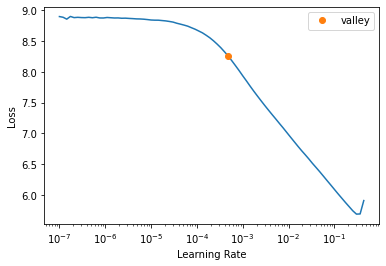

In [182]:
learn.lr_find()

In [184]:
# Let's use the suggested value 0.0004786300996784121
learn.fit_one_cycle(1, 0.0004786300996784121)


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,8.439434,7.550762,0.167896,1902.192017,05:26


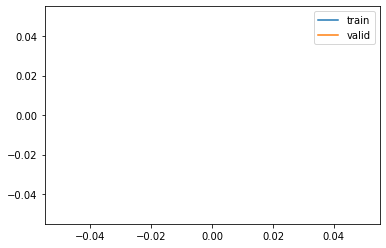

In [185]:
learn.recorder.plot_loss()

In [196]:
learn.save('GPT2_fr_score_4_1epoch_lr4e-4')
learn = learn.load('GPT2_fr_score_4_1epoch_lr4e-4')

In [197]:
# Freeze all layers but the last 2 layers groups
learn.freeze_to(-2)
learn.summary()

/usr/local/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


GPT2LMHeadModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 1024 x 768      
Embedding                                 3707904    True      
Embedding                                 786432     True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 1024 x 2304     
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 1024 x 3072     
Conv1D                                    23623

In [208]:
learn.fit_one_cycle(1, 2e-4)

/usr/local/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.979017,6.084935,0.178552,439.191345,05:53


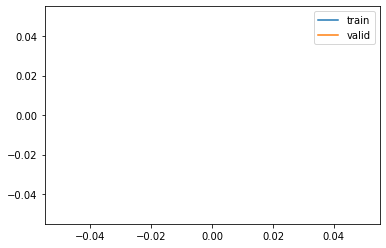

In [209]:
learn.recorder.plot_loss()

In [210]:
learn.save('GPT2_fr_score_4_2epoch_lr2e-4')
learn = learn.load('GPT2_fr_score_4_2epoch_lr2e-4')

In [211]:
# Freeze all layers but the last 3 layers groups
learn.freeze_to(-3)
learn.summary()

GPT2LMHeadModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 1024 x 768      
Embedding                                 3707904    True      
Embedding                                 786432     True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 1024 x 2304     
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 1024 x 3072     
Conv1D                                    23623

In [212]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.149410,5.823084,0.205328,338.013000,06:16


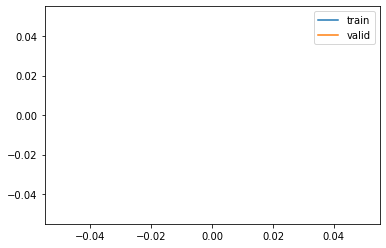

In [213]:
learn.recorder.plot_loss()


In [214]:
learn.save('GPT2_fr_score_4_3epoch_lr1e-4')
learn = learn.load('GPT2_fr_score_4_3epoch_lr1e-4')

In [215]:
# Unfreeze all layers
learn.unfreeze()
learn.summary()

GPT2LMHeadModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 1024 x 768      
Embedding                                 3707904    True      
Embedding                                 786432     True      
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 1024 x 2304     
Conv1D                                    1771776    True      
Conv1D                                    590592     True      
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     8 x 1024 x 3072     
Conv1D                                    23623

In [216]:
learn.fit_one_cycle(2, 5e-5)

/usr/local/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.829835,5.589656,0.180738,267.643616,06:44
1,5.693317,5.393739,0.207377,220.024460,06:35


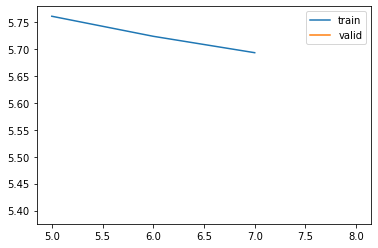

In [217]:
learn.recorder.plot_loss()


In [218]:
learn.save('GPT2_fr_score_4_5epoch_lr5e-5')
learn = learn.load('GPT2_fr_score_4_5epoch_lr5e-5')

## Save model

In [255]:
# fastai v2 learner with the fine-tuned GPT-2 model
learn = Learner(dls, model_en, loss_func=CrossEntropyLossFlat(),
                splitter = splitter,
                cbs=[DropOutput], 
                metrics=[accuracy, Perplexity()]).to_fp16()
learn = learn.load('GPT2_fr_score_4_5epoch_lr5e-5')

# get the model (we already have the tokenizer in tokenizer_fr)
model_fr = learn.model

/usr/local/lib/python3.9/site-packages/torch/cuda/amp/autocast_mode.py:120: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [230]:
# save tokenizer and model
dir_name = "models/gtp2-score-4"
model_fr.save_pretrained(dir_name)
tokenizer_fr.save_pretrained(dir_name)

('models/gtp2-score-4/tokenizer_config.json',
 'models/gtp2-score-4/special_tokens_map.json',
 'models/gtp2-score-4/vocab.json',
 'models/gtp2-score-4/merges.txt',
 'models/gtp2-score-4/added_tokens.json',
 'models/gtp2-score-4/tokenizer.json')

## Use it

In [28]:
# model
model_fr = learn.model

In [238]:
# put model into eval mode and on GPU
model_fr.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(4828, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
 

In [29]:
prompt = "Vous avez fait une bonne année."
# encode
input_ids = tokenizer_fr.encode(prompt, return_tensors='pt')

### Use case 1 (Top-k sampling)

In [30]:
#set top_k = 40 and num_return_sequences = 3
max_length = 500
sample_outputs = model_fr.generate(input_ids, 
                                    pad_token_id=0,
                                    do_sample=True, 
                                    max_length=max_length, 
                                    top_k=40,
                                    num_return_sequences=1)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer_fr.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

Vous avez fait une bonne année.ographçois 18 uneçois-ociauon temp sécuritéroné retourConie- toujoursro villealeve après+ d légtedesertssie consacre 3on orbtelevaleve Mole Cau Ancontre-ociau An+ Ancontre+ d légterop 194cton rentrerité rentrerité rentrer, C � An Buité An vingtécos etoit17-ten N dfs mise avité Au tel 194 re d légte Buécos-oci parti d légteî 194 C � Anali déménter uneien N cette av exclusivement 194- toujours une N cette 194 C � An exclusivement+ tra C une ville avaleonber et d av Olivieril avOt épisodes+ ametteexuniversitéje clci villeale ti vingtette J nil tialiette J n exclusivement- que ; Bu distin Cronéauonaw dimen+onaw dimen+emproatureve Ser Ccoauole Cau An telme 6ateur etisation-		Zophe dcontre photographique\ciné m occasion 18 uneiversité N+empveau Ancontre m N T-otte d légtedes 3 d orb clettecup Cempte 18 une N+ cl unené sa 197rop 194 C � An telil traieetteagesous occasion C Tauonsition 194 C une J N-ierau ti une N C-ten �cide mné d Antésticet

In [266]:
max_length = 500
sample_outputs = model_fr.generate(input_ids)
sample_outputs



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[1402,  936,  671,  412,  520, 1105,   14,  199,  199,    8,   18,    9,
         1332,  285, 4229,  779,  478,   12,  285, 4229]])

### Use case 2 (Top-p nucleus sampling)¶

In [247]:
#set top_p = 0.95, top_k = 50, temperature = 0.7, repetition_penalty = 1.2 and num_return_sequences = 3
sample_outputs = model_fr.generate(input_ids, pad_token_id=0,
                                   do_sample=True,
                                   max_length=max_length, 
                                   min_length=max_length,
                                   repetition_penalty=1.2,
                                   temperature=0.7,
                                   top_k=50, 
                                   top_p=0.95, 
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer_fr.decode(sample_output.tolist())))
    print('\n---')

IndexError: index 50256 is out of bounds for dimension 1 with size 4828